In [3]:
pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:00-:--:--
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import class_weight

from sklearn.preprocessing import label_binarize

In [5]:
# 1. Parameters
IMAGE_SIZE  = (299, 299)
BATCH_SIZE  = 32
LEARNING_RATE = 1e-4
train_dir = '../../data5/train'
test_dir  = '../../data5/test'

# Create data generators with VGG16-specific preprocessing
train_datagen = train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Using the test set as "validation_data" (not ideal practice)
# but shown here due to the 2-folder constraint:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())

print("Number of classes:", num_classes)
print("Class labels:", class_labels)
# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.
Number of classes: 4
Class labels: ['1. Enfeksiyonel', '2. Ekzama', '3. Akne', '4. Malign']


In [6]:
# include_top=False removes InceptionV3's default classifier
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Example: Freeze first 249 layers, unfreeze the rest
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# -------------------------------------------------
# 4. Add a Custom Head (Penultimate Layer = Embeddings)
# -------------------------------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)   # shape: (batch_size, 2048)
x = Dense(256, activation='relu', name='penultimate_layer')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax', name='final_predictions')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,328,356 (85.18 MB)

 Trainable params: 11,640,452 (44.40 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 641s 3s/step - accuracy: 0.6264 - loss: 0.8779 - val_accuracy: 0.7745 - val_loss: 0.5687 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 861s 5s/step - accuracy: 0.8177 - loss: 0.4795 - val_accuracy: 0.8245 - val_loss: 0.4794 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 873s 5s/step - accuracy: 0.8769 - loss: 0.3251 - val_accuracy: 0.8078 - val_loss: 0.5119 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 873s 5s/step - accuracy: 0.9196 - loss: 0.2258 - val_accuracy: 0.8366 - val_loss: 0.4880 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 882s 5s/step - accuracy: 0.9387 - loss: 0.1721 - val_accuracy: 0.8373 - val_loss: 0.5420 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 869s 5s/step - accuracy: 0.9490 - loss: 0.1461 - val_accuracy: 0.8389 - val_loss: 0.5873 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 869s 5s/step - acc

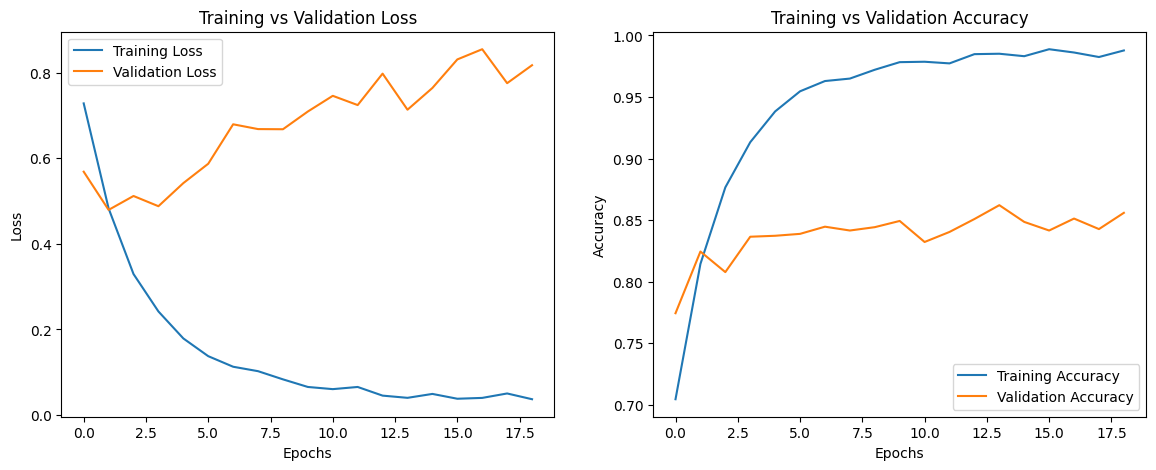

In [9]:
train_loss = history.history['loss']
train_acc  = history.history['accuracy']
val_loss   = history.history['val_loss']
val_acc    = history.history['val_accuracy']

epochs_range = range(len(train_loss))

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss,   label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc,   label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [10]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Test Loss: 0.7136161923408508
Test Accuracy: 0.8621894121170044


In [14]:
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)


Train Loss: 0.08166103810071945
Train Accuracy: 0.9713285565376282


81/81 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step

Classification Report:
                 precision    recall  f1-score   support

1. Enfeksiyonel       0.78      0.79      0.79       650
      2. Ekzama       0.84      0.80      0.82       650
        3. Akne       0.89      0.95      0.92       626
      4. Malign       0.94      0.90      0.92       650

       accuracy                           0.86      2576
      macro avg       0.86      0.86      0.86      2576
   weighted avg       0.86      0.86      0.86      2576

Confusion Matrix:
[[516  75  42  17]
 [ 94 520  21  15]
 [ 19   5 597   5]
 [ 35  17  10 588]]


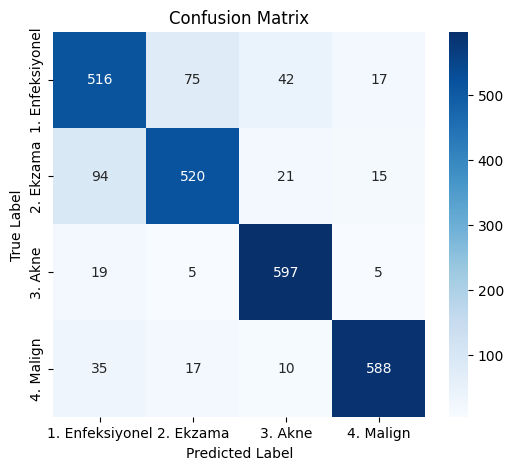

In [11]:
# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels from the test generator
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [ ]:
# 6. Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Val Loss:", test_loss)
print("Val Accuracy:", test_accuracy)

81/81 ━━━━━━━━━━━━━━━━━━━━ 78s 960ms/step - accuracy: 0.8059 - loss: 0.7916
Val Loss: 0.6329536437988281
Val Accuracy: 0.8555900454521179


Macro-average ROC AUC: 0.9456165443222787
Micro-average ROC AUC: 0.9510118585477668


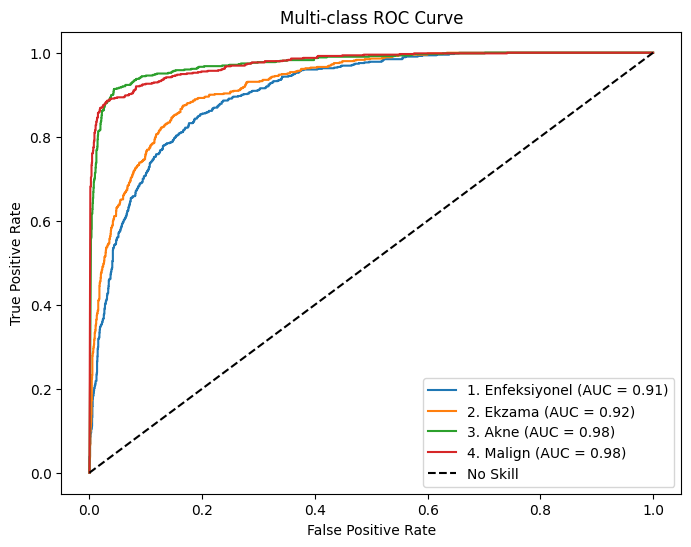

In [16]:
y_true_indices = test_generator.classes

# 8. Multi-class ROC & AUC
y_true_binarized = label_binarize(y_true_indices, classes=range(num_classes))

macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='macro')
micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, 
                              multi_class='ovr', average='micro')
print("Macro-average ROC AUC:", macro_roc_auc)
print("Micro-average ROC AUC:", micro_roc_auc)

fpr = {}
tpr = {}
roc_auc_classwise = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc_classwise[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_labels[i], roc_auc_classwise[i]))

plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.show()